In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe_statevars
import bmi_cfe_peturb

print(bmi_cfe_peturb)


<module 'bmi_cfe_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_peturb.py'>


In [2]:
cfe_instance = bmi_cfe_statevars.BMI_CFE() #one that changes state vars
cfe_peturbed = bmi_cfe_peturb.BMI_CFE()
#print("CFE")
print(cfe_instance.get_input_var_names())
#print()
print(cfe_peturbed.get_input_var_names())


['atmosphere_water__time_integral_of_precipitation_mass_flux', 'water_potential_evaporation_flux', 'state_var_change_soil', 'state_var_change_runoff']
['atmosphere_water__time_integral_of_precipitation_mass_flux', 'water_potential_evaporation_flux', 'state_var_change_soil', 'state_var_change_runoff']


### This initialization function should perform all tasks that are to take place before entering the model’s time loop. Models should be refactored, if necessary, to read their inputs (which could include filenames for other input files) from a configuration file. BMI does not impose any constraint on how configuration files are formatted.

In [3]:
cfe_instance.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
cfe_peturbed.forcing_file # path to forcing file



'./Forcing/cat58_01Dec2015.csv'

### Open the forcing file contained within the configuration file. We can run the model with any forcing. This is only an example. The path to the forcing file is contained within the configuration file, but it doesn't really need to be. This is just for organization.

In [4]:
with open(cfe_instance.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)

                 time  APCP_surface  DLWRF_surface  DSWRF_surface  \
0      12/1/2015 0:00           0.0     361.200012       0.000000   
1      12/1/2015 1:00           0.0     361.200012       0.000000   
2      12/1/2015 2:00           0.0     361.200012       0.000000   
3      12/1/2015 3:00           0.0     357.600006       0.000000   
4      12/1/2015 4:00           0.0     357.600006       0.000000   
..                ...           ...            ...            ...   
715  12/30/2015 19:00           4.7     402.200012     163.600006   
716  12/30/2015 20:00           3.7     402.200012     130.300003   
717  12/30/2015 21:00           4.2     399.200012      80.400002   
718  12/30/2015 22:00           8.3     399.200012      21.000000   
719  12/30/2015 23:00           3.3     399.200012       0.000000   

     PRES_surface  SPFH_2maboveground  TMP_2maboveground  UGRD_10maboveground  \
0          100530              0.0105         287.500000                 -2.6   
1        

### We will want to visualize the model output

In [5]:
# Originial CFE Model
cfe_outputs=cfe_instance.get_output_var_names()
cfe_output_lists = {output:[] for output in cfe_outputs}

print(cfe_output_lists)


{'land_surface_water__runoff_depth': [], 'land_surface_water__runoff_volume_flux': [], 'DIRECT_RUNOFF': [], 'GIUH_RUNOFF': [], 'NASH_LATERAL_RUNOFF': [], 'DEEP_GW_TO_CHANNEL_FLUX': []}


### Now we loop through the forcing data and use it to run the model at each time step

In [6]:
cfe_list = []
cfe_list_p = []

percent_list = np.arange(10, 200, 10)
percentList = percent_list.tolist() #to list for dataframe

for percent in percent_list:
    
    percent=percent/100 #convert to percentage    
#     cfe_instance.set_value('state_var_change_runoff', percent) #value of precip from forcing data in loop
#     cfe_peturbed.set_value('state_var_change_runoff', percent)
    cfe_instance.set_value('state_var_change_soil', percent) #value of precip from forcing data in loop
    cfe_peturbed.set_value('state_var_change_soil', percent)
    #soil is soil_reservoir_storage_deficit_m
    #runoff is the runoff_queue_m_per_timestep
    #
    
    for i, precip in enumerate(df_forcing['APCP_surface']): #i is 
    #for i, precip in enumerate(df_forcing['RAINRATE']):

        framework_time = (1+i)*3600 #seconds since starting simulation

        # Run CFE model
        cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
        cfe_instance.update()
        outflow = cfe_instance.get_value('land_surface_water__runoff_depth')
        
        # Run CFE Peturbed
        cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
        cfe_peturbed.update()
        outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
        # Get mean and covariance for stats of ensemble runs for EnKF
        outflow_peturb_mean = np.mean(outflow_peturb)
    
    # Appen lists outside of for loop
    cfe_list.append(np.mean(outflow)) #CFE State var changes
    cfe_list_p.append(np.mean(outflow_peturb_mean)) #CFE Peturbed State Var changes

df = pd.DataFrame({'Percent_Change_StateVar':percentList,'Mean_Streamflow':cfe_list})
df_p = pd.DataFrame({'Percent_Change_StateVar':percentList,'Mean_Streamflow':cfe_list_p})
#matrix = df.to_numpy() #convert to matirx
#print(matrix)
print(df)
print(df_p)



    Percent_Change_StateVar  Mean_Streamflow
0                        10        31.405473
1                        20        31.411247
2                        30        31.412173
3                        40        31.412197
4                        50        31.412197
5                        60        31.412197
6                        70        31.412197
7                        80        31.412197
8                        90        31.412197
9                       100        31.412197
10                      110        31.412197
11                      120        31.412197
12                      130        31.412197
13                      140        31.412197
14                      150        31.412197
15                      160        31.412197
16                      170        31.412197
17                      180        31.412197
18                      190        31.412197
    Percent_Change_StateVar  Mean_Streamflow
0                        10        37.203360
1         

Percent_Change_StateVar = 0.01(Percent_Change_Streamflow) + 99.0
Percent_Change_StateVar_Peturb = -0.13(Percent_Change_Streamflow_Peturb) + 153.53


,Percent_Change_StateVar,Mean_Streamflow
0,10,99.0
1,20,99.0
2,30,99.0
3,40,99.0
4,50,99.0
5,60,99.0
6,70,100.0
7,80,100.0
8,90,100.0
9,100,100.0


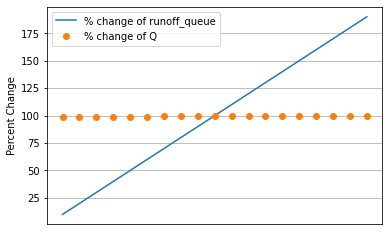

In [7]:
## CFE State vars
no_change = df.loc[df['Percent_Change_StateVar'] == 100]
# # # # # no_change['Sum streamflow']
Q_at_no_change=float(no_change['Mean_Streamflow'])
# # # # # float(Q_at_no_change)
df['Mean_Streamflow']=100*df['Mean_Streamflow']//Q_at_no_change

x = df.iloc[:,0]
y = df.iloc[:,1]
m, b = np.polyfit(x,y,1)
m = round(m, 2)
b = round(b, 2)

print('Percent_Change_StateVar = %s(Percent_Change_Streamflow) + %s' %(m, b))

## CFE Peturbed State vars
no_change_p = df_p.loc[df_p['Percent_Change_StateVar'] == 100]
# # # # # no_change['Sum streamflow']
Q_at_no_change_p = float(no_change_p['Mean_Streamflow'])
# # # # # float(Q_at_no_change)
df_p['Mean_Streamflow']=100*df_p['Mean_Streamflow']//Q_at_no_change_p

x2 = df_p.iloc[:,0]
y2 = df_p.iloc[:,1]
m2, b2 = np.polyfit(x2,y2,1)
m2 = round(m2, 2)
b2 = round(b2, 2)

print('Percent_Change_StateVar_Peturb = %s(Percent_Change_Streamflow_Peturb) + %s' %(m2, b2))

# # # #df['Sum streamflow'][100]
# # # # df['Sum streamflow']#/Q_at_no_change
plt.plot(df['Percent_Change_StateVar'],label='% change of runoff_queue', color='tab:blue')
plt.plot(df['Mean_Streamflow'], 'o', label='% change of Q', color = 'tab:orange')
plt.xticks([])
plt.ylabel('Percent Change')
plt.legend(loc=2)
plt.grid()
df

In [8]:
# Find mean streamflow to based changes on
# df_mean = df['Sum_streamflow'].mean()
#print('The Mean streamflow is %s' %(df_mean))

# If statement to add group to assocaited percent range 
df.loc[df['Percentage'] <=0.25,'Group'] = 1
df.loc[(df['Percentage'] > 0.25) & (df['Percentage'] <= 0.5),'Group'] = 2
df.loc[(df['Percentage'] > 0.5) & (df['Percentage'] <= 1.0),'Group'] = 3
df.loc[(df['Percentage'] > 1.0) & (df['Percentage'] <= 1.5),'Group'] = 4
df.loc[(df['Percentage'] > 1.5) & (df['Percentage'] <= 2.0),'Group'] = 5

# Test runoff
runoff_queue_m_per_timestep = 1
df.loc[(df['Group'] == 3), 'runoff_queue_m_per_timestep'] = runoff_queue_m_per_timestep * 0.1
#print(df)

KeyError: 'Percentage'